# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 

## Lab 4 - Bayesian Analysis

**Harvard University**<br>
**Spring 2020**<br>
**Instructors:** Mark Glickman, Pavlos Protopapas, and Chris Tanner<br>
**Lab Instructors:** Chris Tanner and Eleni Angelaki Kaxiras<br>
**Content:** Eleni Angelaki Kaxiras

---

In [1]:
## RUN THIS CELL TO PROPERLY HIGHLIGHT THE EXERCISES
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2019-CS109B/master/content/styles/cs109.css").text
HTML(styles)

In [2]:
import pymc3 as pm
from pymc3 import summary

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

In [4]:
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.8


In [5]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 20000;

<IPython.core.display.Javascript object>

<a id=top></a>

## Learning Objectives

By the end of this lab, you should be able to:
* Understand how probability distributions work.
* Apply Bayes Rule in calculating probabilities.
* Understand how to apply Bayesian analysis using PyMC3
* Avoid getting fired when talking to your Bayesian employer.

**This lab corresponds to Lectures 6, 7, and 8, and maps to Homework 3.**

## Table of Contents

1. The Bayesian Way of Thinking or Is this a Fair Coin?
2. [Intro to `pyMC3`](#pymc3). 
3. [Bayesian Linear Regression](#blr).
4. [Try this at Home: Example on Mining Disasters](#no4).

## 1. The Bayesian way of Thinking

```
Here is my state of knowledge about the situation. Here is some data, I am now going to revise my state of knowledge.
```

<div class="exercise"  style="background-color:#b3e6ff"><b>Table Exercise</b>: Discuss the statement above with your table mates and make sure everyone understands what it means and what constitutes Bayesian way of thinking. Finally, count the Bayesians among you. </div>

### A. Bayes Rule

\begin{equation}
\label{eq:bayes} 
P(A|\textbf{B}) = \frac{P(\textbf{B} |A) P(A) }{P(\textbf{B})} 
\end{equation}

$P(A|\textbf{B})$ is the **posterior** distribution, prob(hypothesis | data) 

$P(\textbf{B} |A)$ is the **likelihood** function, how probable is my data **B** for different values of the parameters

$P(A)$ is the marginal probability to observe the data, called the **prior**, this captures our belief about the data before observing it.

$P(\textbf{B})$ is the marginal distribution (sometimes called marginal likelihood)

<BR>
<div class="exercise"  style="background-color:#b3e6ff"><b>Table Exercise</b>: Solve the Monty Hall Paradox using Bayes Rule.</div> 

![montyhall](../images/montyhall.jpeg)

You are invited to play a game. There are 3 doors behind **one** of which are the keys to a brand new red Tesla. There is a goat behind each of the other two. 

You are asked to pick one door, and let's say you pick **Door1**. The host knows where the keys are. Of the two remaining closed doors, he will always open the door that has a goat behind it. He'll say "I will do you a favor and open **Door2**". So he opens Door2 inside which there is, of course, a goat. He now asks you, do you want to open the initial Door you chose or change to **Door3**? Generally, in this game, when you are presented with this choice should you swap the doors?

**Initial Steps:**
- Start by defining the `events` of this probabilities game. One definition is:
    
    - $A_i$: car is behind door $i$    
        
    - $B_i$ host opens door $i$
    
$i\in[1,2,3]$
      
- In more math terms, the question is: is the probability that the price is behind **Door 1** higher than the probability that the price is behind **Door2**, given that an event **has occured**?

### B. Bayes Rule written with Probability Distributions

We have data that we believe come from an underlying distribution of unknown parameters. If we find those parameters, we know everything about the process that generated this data and we can make inferences (create new data).

\begin{equation}
\label{eq:bayes} 
P(\theta|\textbf{D}) = \frac{P(\textbf{D} |\theta) P(\theta) }{P(\textbf{D})} 
\end{equation}

#### But what is $\theta \;$?

$\theta$ is an unknown yet fixed set of parameters. In Bayesian inference we express our belief about what $\theta$ might be and instead of trying to guess $\theta$ exactly, we look for its **probability distribution**. What that means is that we are looking for the **parameters** of that distribution. For example, for a Poisson distribution our $\theta$ is only $\lambda$. In a normal distribution, our $\theta$ is often just $\mu$ and $\sigma$.

### C. A review of Common Probability Distributions

#### Discrete Distributions

The random variable has a **probability mass function (pmf)** which measures the probability that our random variable will take a specific value $y$, denoted $P(Y=y)$.

- **Bernoulli** (binary outcome, success has probability $\theta$, $one$ trial):
$
P(Y=k) =  \theta^k(1-\theta)^{1-k}
$
<HR>
- **Binomial** (binary outcome, success has probability $\theta$, $n$ trials):
\begin{equation}
P(Y=k) =  {{n}\choose{k}} \cdot \theta^k(1-\theta)^{n-k}
\end{equation}

*Note*: Binomial(1,$p$) = Bernouli($p$)
<HR>
- **Negative Binomial**
<HR>
- **Poisson** (counts independent events occurring at a rate)
\begin{equation}
P\left( Y=y|\lambda \right) = \frac{{e^{ - \lambda } \lambda ^y }}{{y!}}
\end{equation}
y = 0,1,2,...
<HR>
- **Discrete Uniform** 
<HR>
- **Categorical, or Multinulli** (random variables can take any of K possible categories, each having its own probability; this is a generalization of the Bernoulli distribution for a discrete variable with more than two possible outcomes, such as the roll of a die)
<HR>
- **Dirichlet-multinomial** (a generalization of the beta distribution for many variables)

#### Continuous Distributions

The random variable has a **probability density function (pdf)**.
- **Uniform** (variable equally likely to be near each value in interval $(a,b)$)
\begin{equation}
P(X = x) = \frac{1}{b - a}
\end{equation}
anywhere within the interval $(a, b)$, and zero elsewhere.
<HR>
- **Normal** (a.k.a. Gaussian)
\begin{equation}
X \sim  \mathcal{N}(\mu,\,\sigma^{2})
\end{equation} 

    A Normal distribution can be parameterized either in terms of precision $\tau$ or standard deviation ($\sigma^{2}$. The link between the two is given by
\begin{equation}
\tau = \frac{1}{\sigma^{2}}
\end{equation}
 - Mean $\mu$
 - Variance $\frac{1}{\tau}$ or $\sigma^{2}$
 - Parameters: `mu: float`, `sigma: float` or `tau: float`
<HR>
- **Beta** (variable ($\theta$) taking on values in the interval $[0,1]$, and parametrized by two positive parameters, $\alpha$ and $\beta$ that control the shape of the distribution. 
    
*Note:*Beta is a good distribution to use for priors (beliefs) because its range is $[0,1]$ which is the natural range for a probability and because we can model a wide range of functions by changing the $\alpha$ and $\beta$ parameters.

\begin{equation}
\label{eq:beta} 
P(\theta) = \frac{1}{B(\alpha, \beta)} {\theta}^{\alpha - 1} (1 - \theta)^{\beta - 1} \propto {\theta}^{\alpha - 1} (1 - \theta)^{\beta - 1}
\end{equation}


where the normalisation constant, $B$, is a beta function of $\alpha$ and $\beta$,


\begin{equation}
B(\alpha, \beta) = \int_{t=0}^1 t^{\alpha - 1} (1 - t)^{\beta - 1} dt.
\end{equation}
<HR>
- **Exponential**
<HR>
- **Gamma**



 #### Code Resources:
 - Statistical Distributions in numpy/scipy: [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html)
 - Statistical Distributions in pyMC3: [distributions in PyMC3](https://docs.pymc.io/api/distributions.html) (we will see those below).

<div class="discussion"><b>Exercise: Plot a Discrete variable</b></div>

Change the value of $\mu$ in the Poisson PMF and see how the plot changes. Remember that the y-axis in a discrete probability distribution shows the probability of the random variable having a specific value in the x-axis.

\begin{equation}
P\left( X=k \right) = \frac{{e^{ - \mu } \mu ^k }}{{k!}}
\end{equation}

**stats.poisson.pmf(x, mu)** $\mu$(mu) is our $\theta$ in this case.

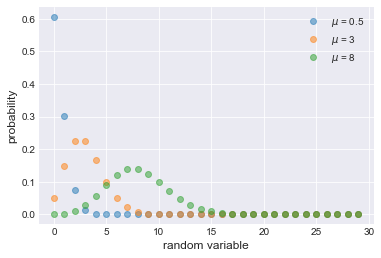

In [6]:
plt.style.use('seaborn-darkgrid')
x = np.arange(0, 30)
for m in [0.5, 3, 8]:
    pmf = stats.poisson.pmf(x, m)
    plt.plot(x, pmf, 'o', alpha=0.5, label='$\mu$ = {}'.format(m))
plt.xlabel('random variable', fontsize=12)
plt.ylabel('probability', fontsize=12)
plt.legend(loc=1)
plt.ylim=(-0.1)
plt.show()

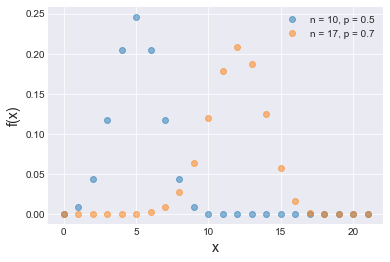

In [7]:
# same for binomial
plt.style.use('seaborn-darkgrid')
x = np.arange(0, 22)
ns = [10, 17]
ps = [0.5, 0.7]
for n, p in zip(ns, ps):
    pmf = stats.binom.pmf(x, n, p)
    plt.plot(x, pmf, 'o', alpha=0.5, label='n = {}, p = {}'.format(n, p))
plt.xlabel('x', fontsize=14)
plt.ylabel('f(x)', fontsize=14)
plt.legend(loc=1)
plt.show()

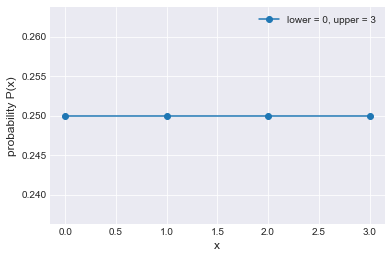

In [8]:
# discrete uniform
plt.style.use('seaborn-darkgrid')
ls = [0]
us = [3] # watch out, this number can only be integer!
for l, u in zip(ls, us):
    x = np.arange(l, u+1)
    pmf = [1.0 / (u - l + 1)] * len(x)
    plt.plot(x, pmf, '-o', label='lower = {}, upper = {}'.format(l, u))
plt.xlabel('x', fontsize=12)
plt.ylabel('probability P(x)', fontsize=12)
plt.legend(loc=1)
plt.show()

<div class="discussion"><b>Exercise: Plot a continuous variable<br></div>

Change the value of $\mu$ in the Uniform PDF and see how the plot changes.
    
Remember that the y-axis in a continuous probability distribution does not shows the actual probability of the random variable having a specific value in the x-axis because that probability is zero!. Instead, to see the probability that the variable is within a small margin we look at the integral below the curve of the PDF.

The uniform is often used as a noninformative prior.

```
Uniform - numpy.random.uniform(a=0.0, b=1.0, size)
```

$\alpha$ and $\beta$ are our parameters. `size` is how many tries to perform.
Our $\theta$ is basically the combination of the parameters a,b. We can also call it 
\begin{equation}
\mu = (a+b)/2
\end{equation}

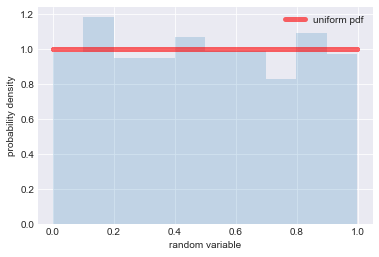

In [9]:
from scipy.stats import uniform

r = uniform.rvs(size=1000)
plt.plot(r, uniform.pdf(r),'r-', lw=5, alpha=0.6, label='uniform pdf')
plt.hist(r, density=True, histtype='stepfilled', alpha=0.2)
plt.ylabel(r'probability density')
plt.xlabel(f'random variable')
plt.legend(loc='best', frameon=False)
plt.show()

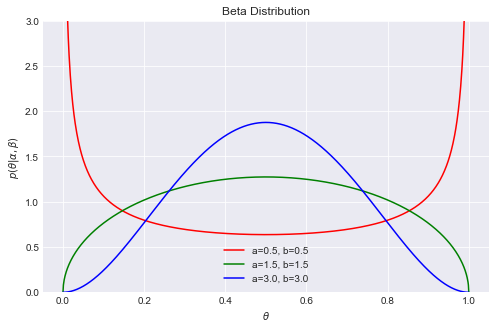

In [10]:
from scipy.stats import beta

alphas = [0.5, 1.5, 3.0]
betas = [0.5, 1.5, 3.0]
x = np.linspace(0, 1, 1000) 
colors = ['red', 'green', 'blue']

fig, ax = plt.subplots(figsize=(8, 5))

for a, b, colors in zip(alphas, betas, colors):
    dist = beta(a, b)
    plt.plot(x, dist.pdf(x), c=colors,
             label=f'a={a}, b={b}')

ax.set_ylim(0, 3)

ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$p(\theta|\alpha,\beta)$')
ax.set_title('Beta Distribution')

ax.legend(loc='best')
fig.show();

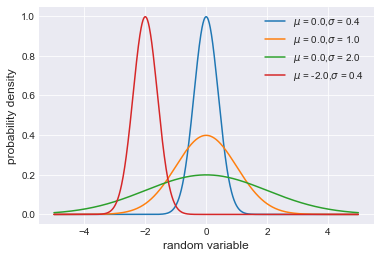

In [11]:
plt.style.use('seaborn-darkgrid')
x = np.linspace(-5, 5, 1000)
mus = [0., 0., 0., -2.]
sigmas = [0.4, 1., 2., 0.4]
for mu, sigma in zip(mus, sigmas):
    pdf = stats.norm.pdf(x, mu, sigma)
    plt.plot(x, pdf, label=r'$\mu$ = '+ f'{mu},' + r'$\sigma$ = ' + f'{sigma}') 
plt.xlabel('random variable', fontsize=12)
plt.ylabel('probability density', fontsize=12)
plt.legend(loc=1)
plt.show() # normal distribution

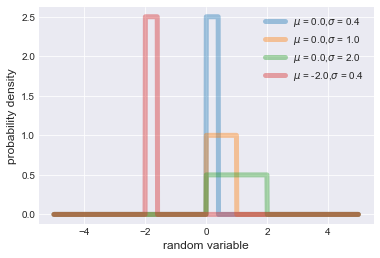

In [12]:
plt.style.use('seaborn-darkgrid')
x = np.linspace(-5, 5, 1000)
mus = [0., 0., 0., -2.] # mean
sigmas = [0.4, 1., 2., 0.4] # std
for mu, sigma in zip(mus, sigmas):
      plt.plot(x, uniform.pdf(x, mu, sigma), lw=5, alpha=0.4, \
               label=r'$\mu$ = '+ f'{mu},' + r'$\sigma$ = ' + f'{sigma}')
plt.xlabel('random variable', fontsize=12)
plt.ylabel('probability density', fontsize=12)
plt.legend(loc=1)
plt.show()

### D. Is this a Fair Coin?

We do not want to promote gambling but let's say you visit the casino in **Monte Carlo**. You want to test your theory that casinos are dubious places where coins have been manipulated to have a larger probability for tails. So you will try to estimate how fair a coin is based on 100 flips. <BR>
You begin by flipping the coin. You get either Heads ($H$) or Tails ($T$) as our observed data and want to see if your posterior probabilities change as you obtain more data, that is, more coin flips. A nice way to visualize this is to plot the posterior probabilities as we observe more flips (data). 

We will be using Bayes rule. $\textbf{D}$ is our data.

\begin{equation}
\label{eq:bayes} 
P(\theta|\textbf{D}) = \frac{P(\textbf{D} |\theta) P(\theta) }{P(\textbf{D})} 
\end{equation}

In the case of a coin toss when we observe $k$ heads in $n$ tosses:
\begin{equation}
\label{eq:bayes} 
P(\theta|\textbf{k}) = Beta(\alpha + \textbf{k}, \beta + n - \textbf{k}) 
\end{equation}

we can say that $\alpha$ and $\beta$ play the roles of a "prior number of heads" and "prior number of tails".

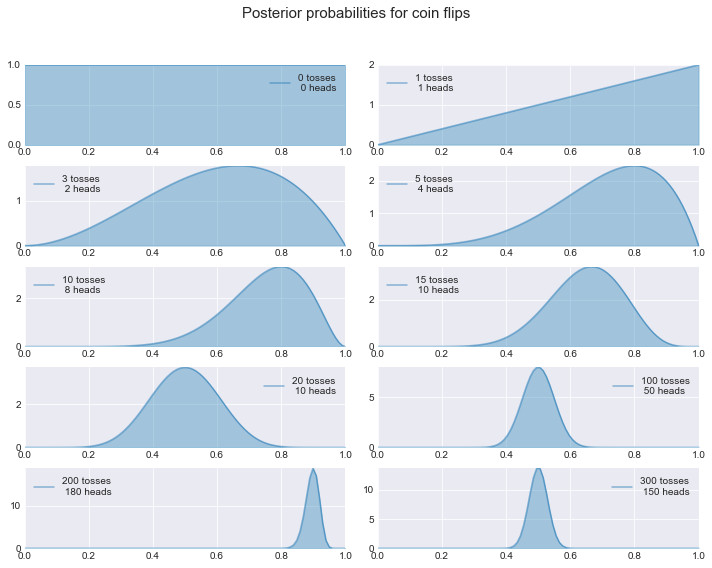

In [13]:
# play with the priors - here we manually set them but we could be sampling from a separate Beta
trials = np.array([0, 1, 3, 5, 10, 15, 20, 100, 200, 300])
heads = np.array([0, 1, 2, 4, 8, 10, 10, 50, 180, 150])
x = np.linspace(0, 1, 100)

# for simplicity we set a,b=1

plt.figure(figsize=(10,8))
for k, N in enumerate(trials):
    sx = plt.subplot(len(trials)/2, 2, k+1)
    posterior = stats.beta.pdf(x, 1 + heads[k], 1 + trials[k] - heads[k]) 
    plt.plot(x, posterior, alpha = 0.5, label=f'{trials[k]} tosses\n {heads[k]} heads');
    plt.fill_between(x, 0, posterior, color="#348ABD", alpha=0.4) 
    plt.legend(loc='upper left', fontsize=10)
    plt.legend()
    plt.autoscale(tight=True)
    
plt.suptitle("Posterior probabilities for coin flips", fontsize=15);
plt.tight_layout()
plt.subplots_adjust(top=0.88)

<a id=pymc3></a> [Top](#top)

## 2. Introduction to `pyMC3`
 
PyMC3 is a Python library for programming Bayesian analysis, and more specifically, data creation, model definition, model fitting, and posterior analysis. It uses the concept of a `model` which contains assigned parametric statistical distributions to unknown quantities in the model. Within models we define random variables and their distributions. A distribution requires at least a `name` argument, and other `parameters` that define it. You may also use the `logp()` method in the model to build the model log-likelihood function. We define and fit the model.

PyMC3 includes a comprehensive set of pre-defined statistical distributions that can be used as model building blocks. Although they are not meant to be used outside of a `model`, you can invoke them by using the prefix `pm`, as in `pm.Normal`. 

#### Markov Chain Monte Carlo (MCMC) Simulations

PyMC3 uses the **No-U-Turn Sampler (NUTS)** and the **Random Walk Metropolis**, two Markov chain Monte Carlo (MCMC) algorithms for sampling in posterior space. Monte Carlo gets into the name because when we sample in posterior space, we choose our next move via a pseudo-random process. NUTS is a sophisticated algorithm that can handle a large number of unknown (albeit continuous) variables.

In [14]:
with pm.Model() as model:
    z = pm.Normal('z', mu=0., sigma=5.)              
    x = pm.Normal('x', mu=z, sigma=1., observed=5.) 
print(x.logp({'z': 2.5})) 
print(z.random(10, 100)[:10])                          

-4.043938533204672
[ 1.6457785   0.16871179  0.74459739  2.87053406  3.52186727 -0.41338343
 -3.96604559  1.87358442 -1.51953071  2.53360101]


**References**:

- *Salvatier J, Wiecki TV, Fonnesbeck C. 2016. Probabilistic programming in Python using PyMC3. PeerJ Computer Science 2:e55* [(https://doi.org/10.7717/peerj-cs.55)](https://doi.org/10.7717/peerj-cs.55)
- [Distributions in PyMC3](https://docs.pymc.io/api/distributions.html)
- [More Details on Distributions](https://docs.pymc.io/developer_guide.html)

Information about PyMC3 functions including descriptions of distributions, sampling methods, and other functions, is available via the `help` command.

In [15]:
#help(pm.Poisson)

<a id=blr></a> [Top](#top)

## 3. Bayesian Linear Regression

Let's say we want to predict outcomes Y as normally distributed observations with an expected value $mu$ that is a linear function of two predictor variables, $\bf{x}_1$ and $\bf{x}_2$.

\begin{equation}
\mu = \alpha + \beta_1 \bf{x}_1 + \beta_2 x_2 
\end{equation}

\begin{equation}
Y \sim  \mathcal{N}(\mu,\,\sigma^{2})
\end{equation} 

where $\sigma^2$ represents the measurement error. 

In this example, we will use $\sigma^2 = 10$

We also choose the parameters as normal distributions:

\begin{eqnarray}
\alpha \sim  \mathcal{N}(0,\,10) \\
\beta_i \sim  \mathcal{N}(0,\,10) \\
\sigma^2 \sim  |\mathcal{N}(0,\,10)|
\end{eqnarray}   

We will artificially create the data to predict on. We will then see if our model predicts them correctly.

Text(0, 0.5, '$Y$')

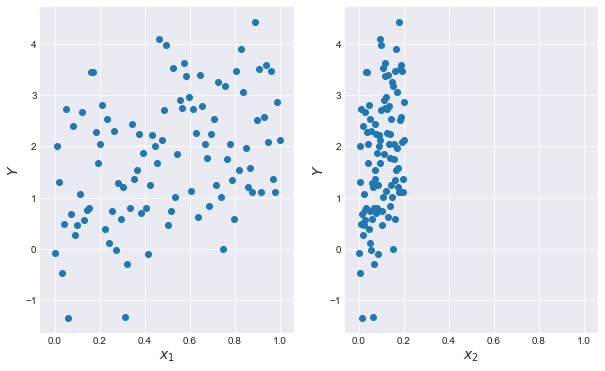

In [16]:
# Initialize random number generator
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.linspace(0, 1, size)
X2 = np.linspace(0,.2, size)

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

fig, ax = plt.subplots(1,2, figsize=(10,6), sharex=True)
ax[0].scatter(X1,Y)
ax[1].scatter(X2,Y)
ax[0].set_xlabel(r'$x_1$', fontsize=14) 
ax[0].set_ylabel(r'$Y$', fontsize=14)
ax[1].set_xlabel(r'$x_2$', fontsize=14) 
ax[1].set_ylabel(r'$Y$', fontsize=14)

In [17]:
from pymc3 import Model, Normal, HalfNormal

basic_model = Model()

with basic_model:

    # Priors for unknown model parameters, specifically create stochastic random variables 
    # with Normal prior distributions for the regression coefficients,
    # and a half-normal distribution for the standard deviation of the observations, σ.
    alpha = Normal('alpha', mu=0, sd=10)
    beta = Normal('beta', mu=0, sd=10, shape=2)
    sigma = HalfNormal('sigma', sd=1)

    # Expected value of outcome - posterior
    mu = alpha + beta[0]*X1 + beta[1]*X2

    # Likelihood (sampling distribution) of observations
    Y_obs = Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

In [ ]:
# model fitting with sampling
from pymc3 import NUTS, sample, find_MAP
from scipy import optimize

with basic_model:

    # obtain starting values via MAP
    start = find_MAP(fmin=optimize.fmin_powell)

    # instantiate sampler
    step = NUTS(scaling=start)

    # draw 2000 posterior samples
    trace = sample(2000, step, start=start)

logp = -164.5:   5%|▌         | 270/5000 [00:00<00:01, 2394.60it/s] 

Optimization terminated successfully.
         Current function value: 164.496957
         Iterations: 6
         Function evaluations: 271


logp = -164.5:   5%|▌         | 271/5000 [00:01<00:17, 267.60it/s] 


In [ ]:
from pymc3 import traceplot

traceplot(trace);

In [ ]:
results = pm.summary(trace, 
                     var_names=['alpha', 'beta', 'sigma'])
results

This linear regression example is from the original paper on PyMC3: *Salvatier J, Wiecki TV, Fonnesbeck C. 2016. Probabilistic programming in Python using PyMC3. PeerJ Computer Science 2:e55 https://doi.org/10.7717/peerj-cs.55*

<a id=no4></a> [Top](#top)

## 4. Try this at Home: Example on Mining Disasters
We will go over the classical `mining disasters from 1851 to 1962` dataset. 

This example is from the [pyMC3 Docs](https://docs.pymc.io/notebooks/getting_started.html).

In [ ]:
import pandas as pd
disaster_data = pd.Series([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                           3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                           2, 2, 3, 4, 2, 1, 3, np.nan, 2, 1, 1, 1, 1, 3, 0, 0,
                           1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                           0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                           3, 3, 1, np.nan, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                           0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])
fontsize = 12
years = np.arange(1851, 1962)
plt.figure(figsize=(10,5))
#plt.scatter(years, disaster_data); 
plt.bar(years, disaster_data)
plt.ylabel('Disaster count', size=fontsize)
plt.xlabel('Year', size=fontsize);
plt.title('Was there a Turning Point in Mining disasters from 1851 to 1962?', size=15);

#### Building the model

**Step1:** We choose the probability model for our experiment. Occurrences of disasters in the time series is thought to follow a **Poisson** process with a large **rate** parameter in the early part of the time series, and from one with a smaller **rate** in the later part. We are interested in locating the change point in the series, which perhaps is related to changes in mining safety regulations. 

```
disasters = pm.Poisson('disasters', rate, observed=disaster_data)
```

We have two rates, `early_rate` if $t<=s$, and `late_rate` if $t>s$, where $s$ is the year the switch was made (a.k.a. the `switchpoint`). 

**Step2:** Choose a prior distributions of the two rates, what we believe the rates were before we observed the data, and the switchpoint. We choose Exponential.
```
early_rate = pm.Exponential('early_rate', 1)
```

The parameters of this model are: 


**Note:** Watch for missing values. Missing values are handled transparently by passing a MaskedArray or a pandas.DataFrame. Behind the scenes, another random variable, disasters.missing_values is created to model the missing values. If you pass a np.array with missing values you will get an error.

In [ ]:
with pm.Model() as disaster_model:

    # discrete
    switchpoint = pm.DiscreteUniform('switchpoint', lower=years.min(), upper=years.max(), testval=1900)

    # Priors for pre- and post-switch rates number of disasters
    early_rate = pm.Exponential('early_rate', 1)
    late_rate = pm.Exponential('late_rate', 1)

    # our theta - allocate appropriate Poisson rates to years before and after current
    # switch is an `if` statement in puMC3
    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)

    # our observed data as a likelihood function of the `rate` parameters
    # shows how we think our data is distributed
    disasters = pm.Poisson('disasters', rate, observed=disaster_data)

#### Model Fitting

In [ ]:
# there are defaults but we can also more explicitly set the sampling algorithms
with disaster_model:
    
    # for continuous variables
    step1 = pm.NUTS([early_rate, late_rate])
    
    # for discrete variables
    step2 = pm.Metropolis([switchpoint, disasters.missing_values[0]] )

    trace = pm.sample(10000, step=[step1, step2])
    # try different number of samples
    #trace = pm.sample(5000, step=[step1, step2])

#### Posterior Analysis

On the left side plots we notice that our early rate is between 2.5 and 3.5 disasters a year. In the late period it seems to be between 0.6 and 1.2 so definitely lower.

The right side plots show the samples we drew to come to our conclusion.

In [ ]:
pm.traceplot(trace, ['early_rate', 'late_rate', 'switchpoint'], figsize=(20,10));

In [ ]:
results = pm.summary(trace, 
                     var_names=['early_rate', 'late_rate', 'switchpoint'])
results